In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
from pandas.tseries import offsets
import os
from datetime import date
import holidays
from collections import OrderedDict
import matplotlib.ticker as tkr
from scipy.stats import mstats

pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline  
blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
sns.set_palette(sns.color_palette("Paired", 10))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
uk_hol= holidays.UK() #load UK holiday
season_dict = {"Winter":1, "Spring":2, "Summer":3, "Autumn":4}

In [57]:
import os
print(os.getcwd())
computer_path= ""
for x in os.getcwd().split("\\"):
    print(x)
    computer_path=computer_path+x+"\\"
    if x == "OneDrive - Cardiff University":
        break    
print(computer_path)

C:\Users\sceac10\OneDrive - Cardiff University\05 - Python\02 - Warwick
C:
Users
sceac10
OneDrive - Cardiff University
C:\Users\sceac10\OneDrive - Cardiff University\


In [58]:
path = computer_path+ '/04 - Projects/02 - Warwick/04 - Data/Data 2016/'
file = "Warwick data.csv"

In [59]:
def cleanAndPrepare(data, meterName):
    print(meterName)
    data["Date"]=data["Date"] + " " +data["StartTime"]
    data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y %H:%M")
    data.set_index("Date", drop=True, inplace=True)
    data.drop(["Meter", "Name", "SerialNumber", "Register", "StartTime", "Duration", "TotalValue", "Unit"], axis=1, inplace=True)
    data.columns = [meterName]
    
def get_season(row):
    if row['Month'] >= 3 and row['Month'] <= 5:
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 8:
        return 'Summer'
    elif row['Month'] >= 9 and row['Month'] <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    
def addTimePeriod(data):
    data["Hour"] = data.index.hour
    data["DayOfWeek_name"]= [calendar.day_name[x] for x in data.index.dayofweek]
    data["DayOfWeek"]= data.index.dayofweek
    data["Month"] =data.index.month
    data["Month name"] = [calendar.month_name[x] for x in data["Month"]]
    data["Weekday"] = [1 if x<5 else 0 for x in data.index.dayofweek]
    data["HH"] = [x%48 for x in range(0, data.shape[0], 1) ]
    # result["Holiday"]= [1 if x.date() in uk_hol else 0 for x in result.index]
    data["Date"] = data.index.date
    data["Week"] = data.index.week

    inv_season_dict = {v: k for k, v in season_dict.items()}
    data['Season'] = result.apply(get_season, axis=1)
    data['Season num'] = data['Season']
    data.replace({"Season num":season_dict}, inplace=True)

    

In [60]:
frames = []

for filename in os.listdir(path):
    if os.path.splitext(filename)[1]==".csv":
        data = pd.read_csv(path+filename)
        meterName = filename.split(".csv")[0]
        cleanAndPrepare(data, meterName)
        print(filename + " has " + '{:d}'.format(data[meterName].isnull().sum()) + " missing data")
        frames.append(data)

result = pd.concat(frames,axis=1)
result.set_index(pd.date_range(start=result.index[0], end=result.index[-1], freq='30T' ), inplace=True)
print(result.columns)
result.columns = ["Boiler heat", "CHP elec", "CHP heat", "Dumped heat", "Heat gen - Heat demand", "Electricity demand", "Gas demand", "Heat demand"]
col = result.columns

addTimePeriod(result)

result.head()

Boilers Heat (MWh)
Boilers Heat (MWh).csv has 0 missing data
CHP generation (kWh)
CHP generation (kWh).csv has 0 missing data
CHP Heat (MWh)
CHP Heat (MWh).csv has 0 missing data
Dumped heat calculated
Dumped heat calculated.csv has 0 missing data
Heat generation minus Main output
Heat generation minus Main output.csv has 0 missing data
Total electricity demand
Total electricity demand.csv has 0 missing data
Total gas demand
Total gas demand.csv has 0 missing data
Total output heat
Total output heat.csv has 0 missing data
Index(['Boilers Heat (MWh)', 'CHP generation (kWh)', 'CHP Heat (MWh)',
       'Dumped heat calculated', 'Heat generation minus Main output',
       'Total electricity demand', 'Total gas demand', 'Total output heat'],
      dtype='object')


,Boiler heat,CHP elec,CHP heat,Dumped heat,Heat gen - Heat demand,Electricity demand,Gas demand,Heat demand,Hour,DayOfWeek_name,DayOfWeek,Month,Month name,Weekday,HH,Date,Week,Season,Season num
2016-01-01 00:00:00,2.09,"2,480.00",0.38,0.00,-0.60,"2,536.00","4,476.00",2.83,0,Friday,4,1,January,1,0,2016-01-01,53,Winter,1
2016-01-01 00:30:00,2.53,"2,483.00",0.40,0.00,0.14,"2,519.00","5,240.00",2.59,0,Friday,4,1,January,1,1,2016-01-01,53,Winter,1
2016-01-01 01:00:00,2.17,"2,479.00",0.41,0.00,-0.14,"2,539.00","4,585.00",2.42,1,Friday,4,1,January,1,2,2016-01-01,53,Winter,1
2016-01-01 01:30:00,1.68,"2,476.00",0.36,0.00,-0.42,"2,525.00","4,257.00",2.27,1,Friday,4,1,January,1,3,2016-01-01,53,Winter,1
2016-01-01 02:00:00,2.83,"2,476.00",0.36,0.00,-0.81,"2,518.00","5,022.00",3.40,2,Friday,4,1,January,1,4,2016-01-01,53,Winter,1


## Baseload, max, min and mean

In [61]:
result["Heat demand"]=result["Heat demand"]*1000 #convert to kWh
result["Boiler heat"]=result["Boiler heat"]*1000 #convert to kWh
result["CHP heat"]=result["CHP heat"]*1000 #convert to kWh

#Remove outlier from the boiler data
x = mstats.winsorize(result["Boiler heat"], limits=[0.01, 0.01])
result["Boiler heat"]=x
result[col].describe(percentiles=[0.05,0.95])

,Boiler heat,CHP elec,CHP heat,Dumped heat,Heat gen - Heat demand,Electricity demand,Gas demand,Heat demand
count,"17,568.00","17,568.00","17,568.00","17,568.00","17,568.00","17,568.00","17,568.00","17,568.00"
mean,668.82,"2,367.49",889.12,0.11,-0.10,"3,605.57","3,587.61","1,512.89"
std,946.52,773.81,572.78,0.14,0.70,638.57,"2,635.09","1,273.49"
min,0.00,5.00,0.00,0.00,-3.51,"1,402.00",0.00,0.00
5%,0.00,"1,212.00",10.00,0.00,-1.28,"2,799.00",0.00,10.00
50%,11.00,"2,432.00",800.00,0.03,-0.05,"3,455.00","3,821.00","1,330.00"
95%,"2,680.00","3,873.00","1,930.00",0.38,1.02,"4,724.00","7,969.00","3,736.50"
max,"3,620.00","3,942.00","4,110.00",0.53,4.11,"5,358.00","11,026.00","6,120.00"


In [62]:
result[col].sum()

Boiler heat              11,749,778.00
CHP elec                 41,592,095.00
CHP heat                 15,620,130.00
Dumped heat                   1,911.84
Heat gen - Heat demand       -1,673.85
Electricity demand       63,342,584.00
Gas demand               63,027,209.00
Heat demand              26,578,400.00
dtype: float64

## Electricity demand 

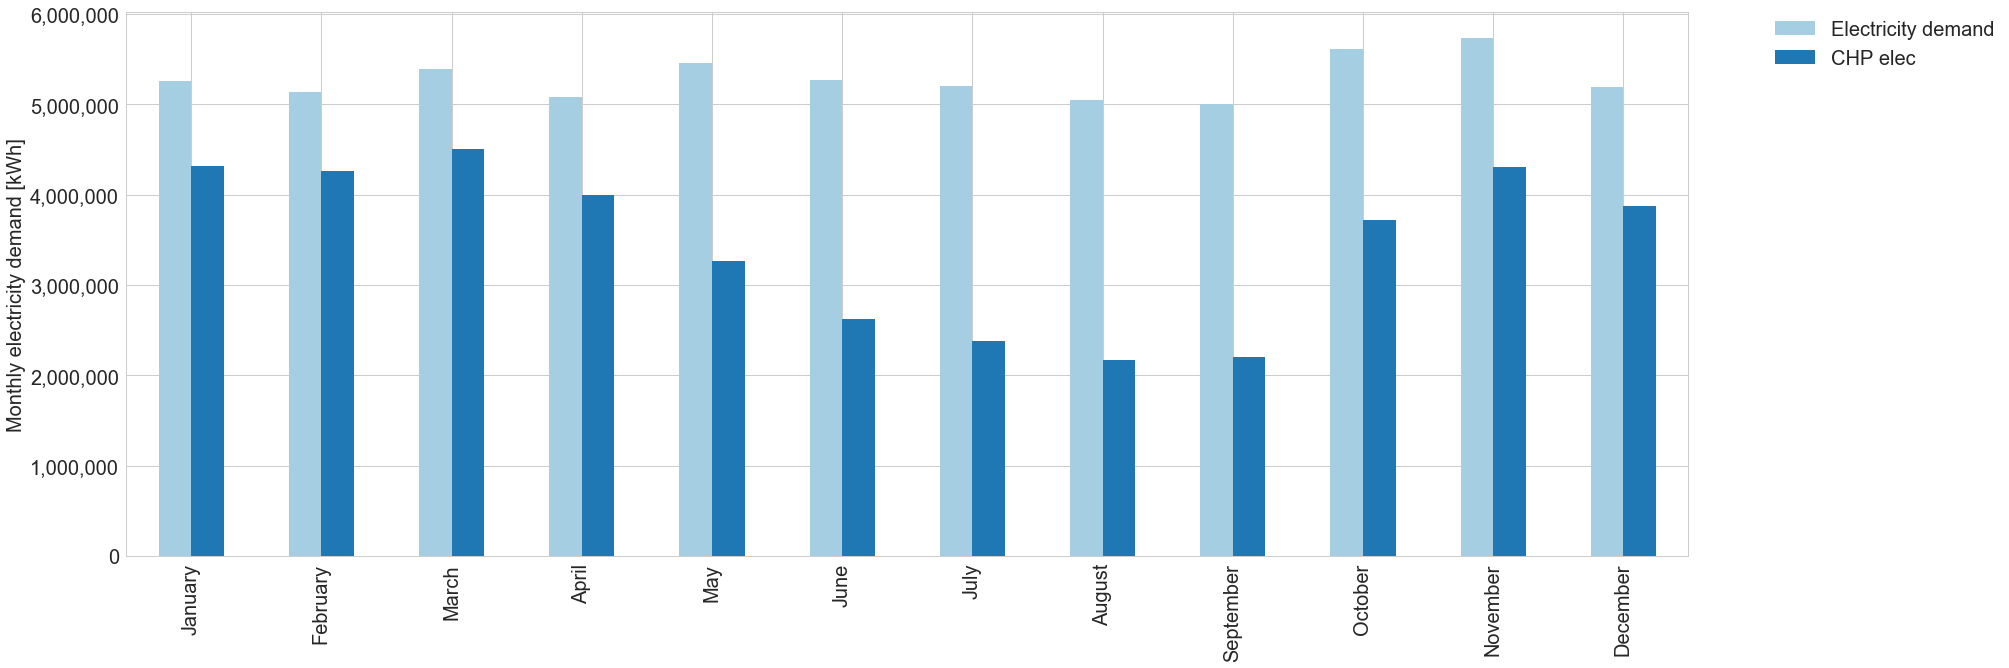

In [63]:
fig, ax = plt.subplots(figsize=(28, 10))
resample='m'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)

resampled_df.plot.bar(ax=fig.gca(),linewidth=2,x="Month name", y=["Electricity demand", "CHP elec"], fontsize=20)
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.set_xlabel("Time", fontsize=20)
ax.xaxis.label.set_visible(False)
ax.set_ylabel("Monthly electricity demand [kWh]", fontsize=20)
# ax.legend_.remove()
# plt.legend(prop={'size':20}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(prop={'size':20}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(path+"Electricity_month.png", bbox_inches='tight')

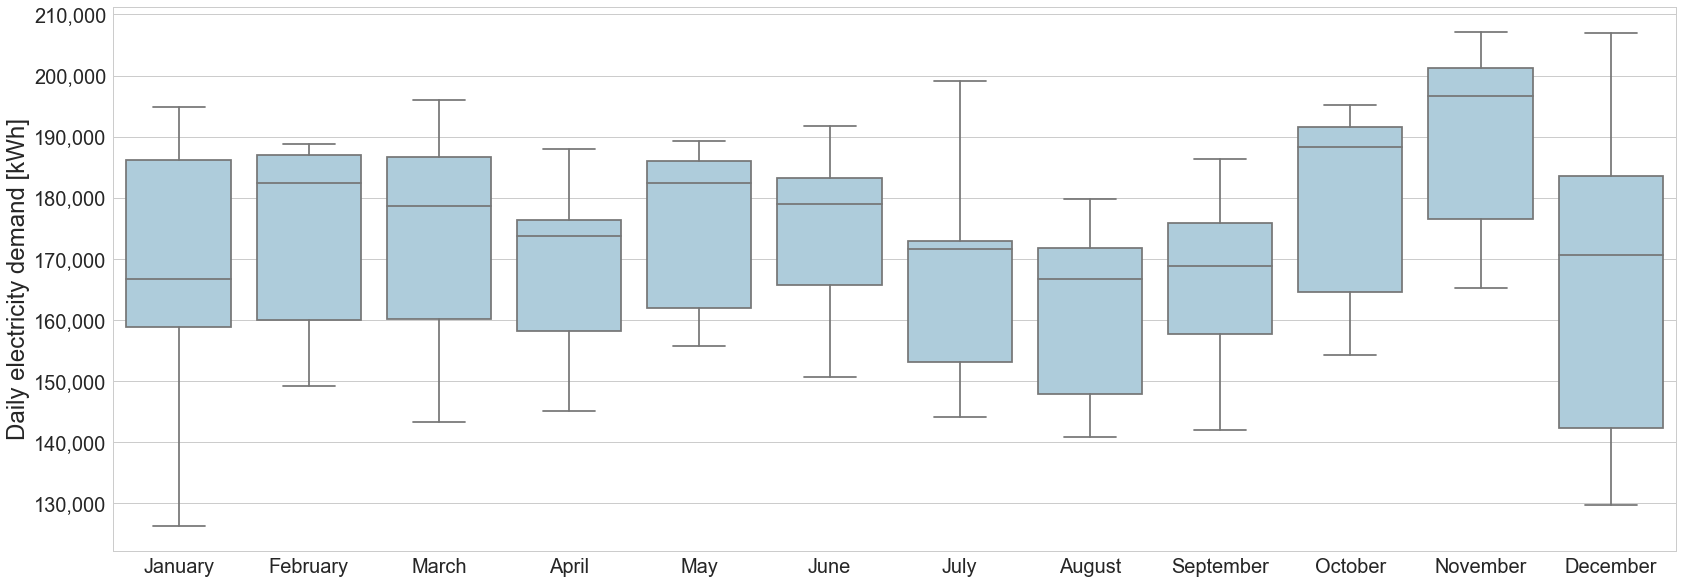

In [64]:
resample='d'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)

fig, ax = plt.subplots(figsize=(28, 10))
sns.boxplot(x="Month name", y="Electricity demand", data=resampled_df, color=sns.color_palette()[0])
ax.xaxis.label.set_visible(False)
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel("Daily electricity demand [kWh]", fontsize=24)
ax.tick_params(labelsize=20)

plt.savefig(path+"Electricity_month_boxplot.png")

## Heat demand 

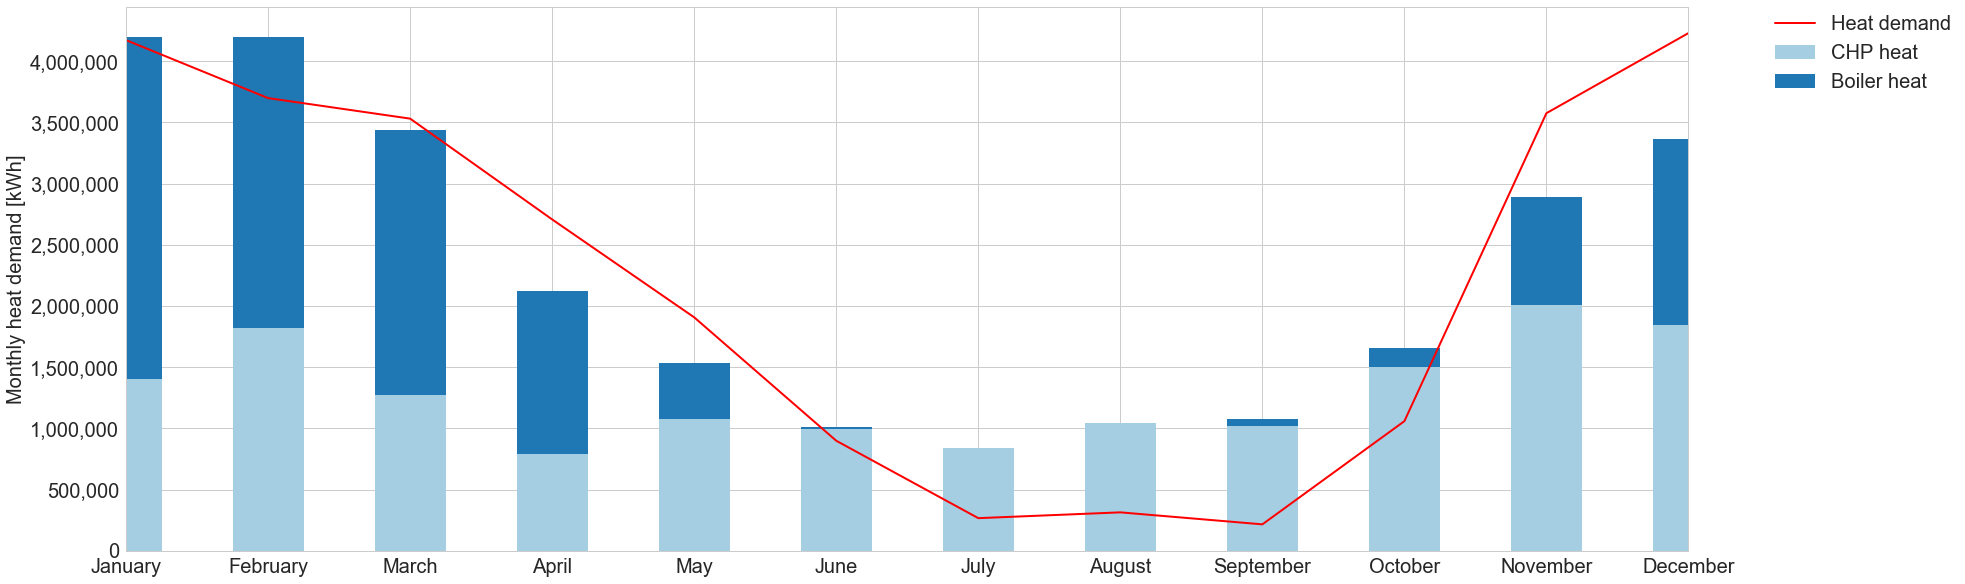

In [65]:
fig, ax = plt.subplots(figsize=(28, 10))
resample='m'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)


resampled_df.plot.bar(ax=fig.gca(),linewidth=2,x="Month name", y=["CHP heat", "Boiler heat"], stacked=True, fontsize=20)
resampled_df.plot(ax=fig.gca(),linewidth=2,x="Month name", y="Heat demand", fontsize=20, color='red')
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.set_xlabel("Time", fontsize=20)
ax.xaxis.label.set_visible(False)
ax.set_ylabel("Monthly heat demand [kWh]", fontsize=20)
# ax.legend_.remove()
plt.legend(prop={'size':20}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(path+"Heat_month.png", bbox_inches='tight')

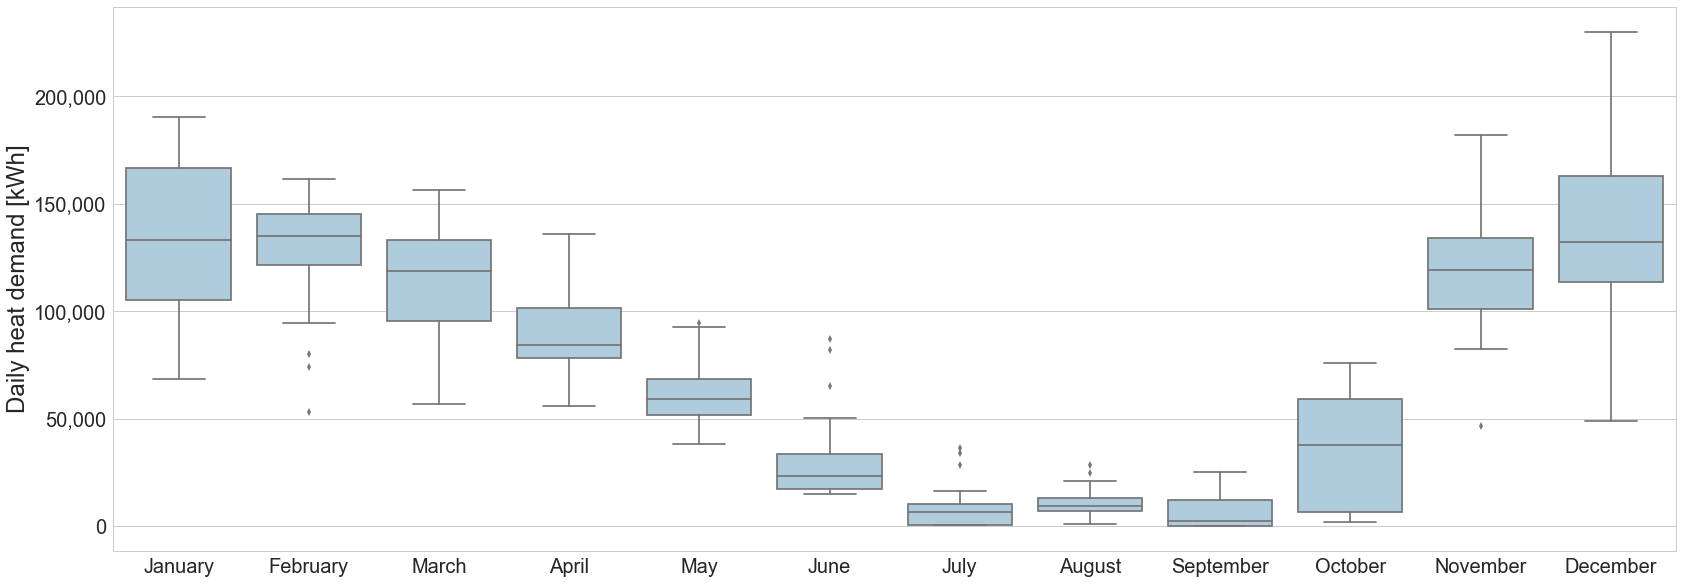

In [66]:
resample='d'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)

fig, ax = plt.subplots(figsize=(28, 10))
sns.boxplot(x="Month name", y="Heat demand", data=resampled_df, color=sns.color_palette()[0])
ax.xaxis.label.set_visible(False)
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel("Daily heat demand [kWh]", fontsize=24)
ax.tick_params(labelsize=20)

plt.savefig(path+"Heat_month_boxplot.png")

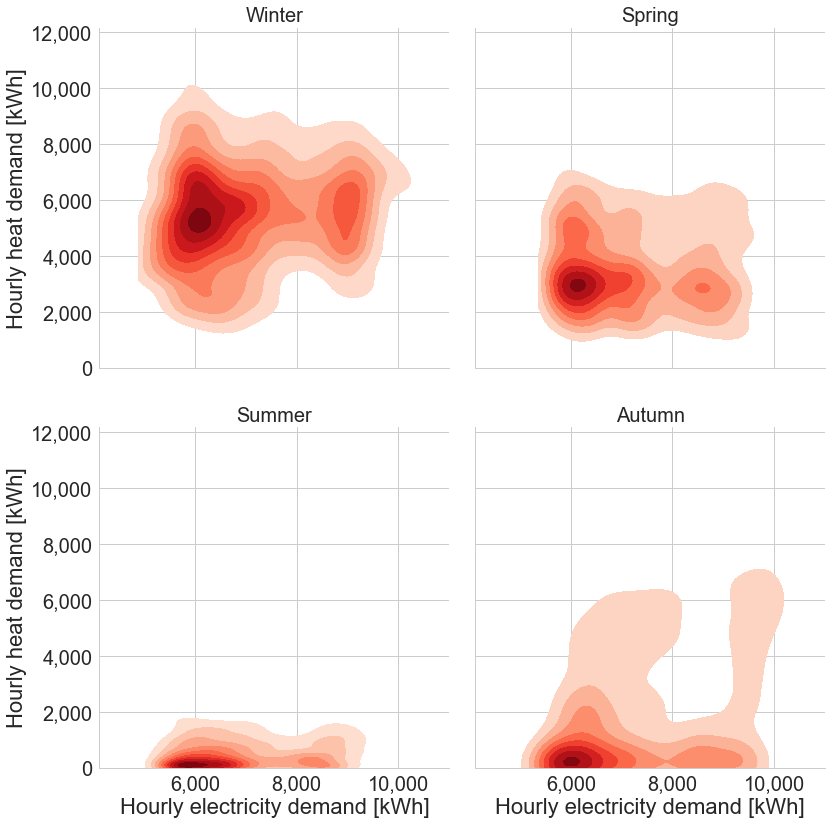

In [67]:
resample='h'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)

# sns.set(font_scale = 2)
g = sns.FacetGrid(resampled_df, col="Season", size = 6, col_wrap=2)
g= g.map(sns.kdeplot, "Electricity demand", "Heat demand", shade=True, cmap="Reds", shade_lowest=False, cut=0)

g.set_axis_labels("Hourly electricity demand [kWh]", "Hourly heat demand [kWh]")
g.set_titles(col_template="{col_name}", size=20)

for ax in g.axes:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,}".format(int(x))))
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,}".format(int(x))))
    
    xaxis=ax.get_xticks()
    xaxis=xaxis[np.where(xaxis>=0)]
    yaxis=ax.get_yticks()
    yaxis=yaxis[np.where(yaxis>=0)]
    if len(xaxis)>7:   
        ax.set_xticks(xaxis[::2])
        ax.set_yticks(yaxis[::2])
        

plt.savefig(path+"Heat demand against electricity.png")

In [68]:
season= "Summer"
bins_size = 10
H, xedges, yedges= np.histogram2d(x=result.loc[result["Season"]==season, "Electricity demand"], y=result.loc[result["Season"]==season, "Heat demand"], bins=bins_size)
H= H.T
length_data = result.loc[result["Season"]==season, :].shape[0]
histogram=pd.DataFrame(data=H/length_data, columns= xedges[1:], index=yedges[1:])
# histogram.to_csv(path+"Histogram-"+season+".csv")

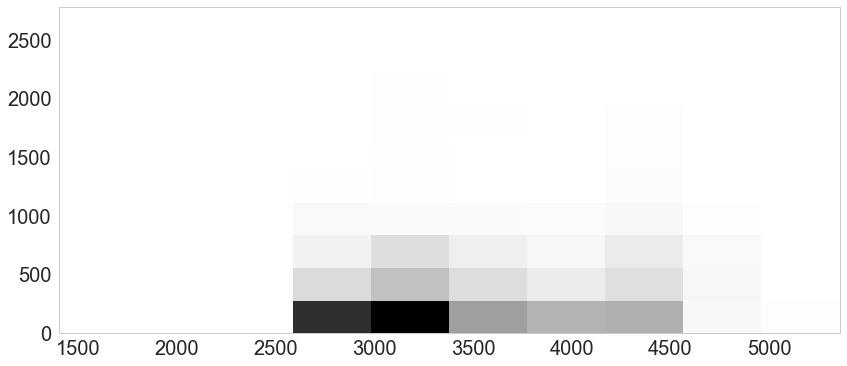

In [69]:
fig, ax = plt.subplots(figsize=(14, 6))
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

In [70]:
length_data = result.loc[result["Season"]=="Winter", :].shape[0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000124E82E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000014B257B8>]], dtype=object)

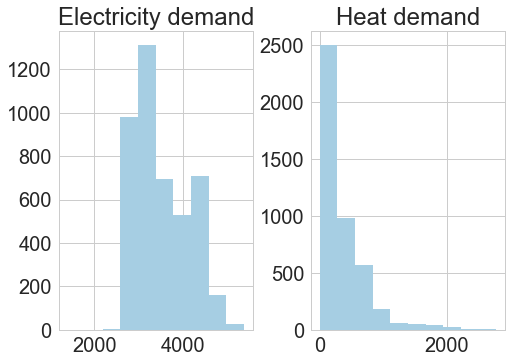

In [71]:
result.loc[result["Season"]==season, ["Electricity demand", "Heat demand"]].hist()

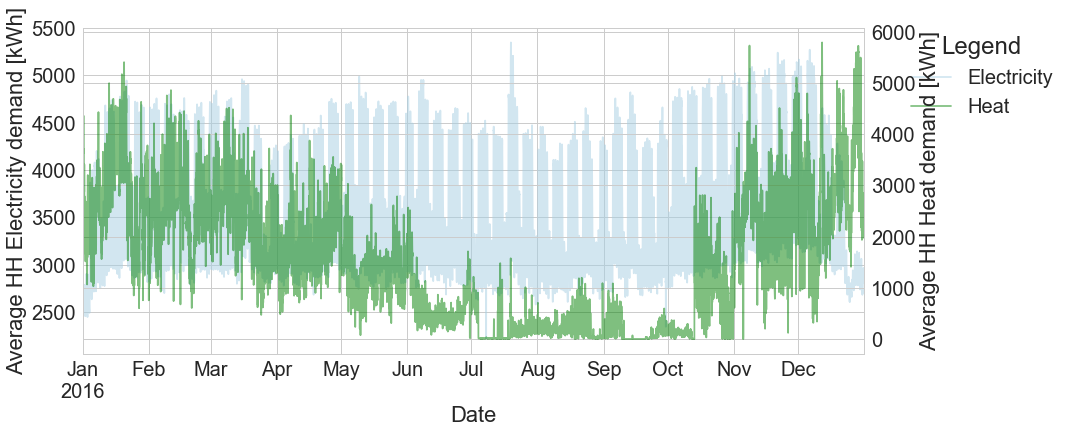

In [72]:

fig, ax = plt.subplots(figsize=(14, 6))
ax2 = ax.twinx()
result.loc[:, "Electricity demand"].resample('h').mean().plot(ax=ax, alpha=0.5, label="Electricity")
result.loc[:, "Heat demand"].resample('h').mean().plot(ax=ax2, color='green', alpha=0.5, label="Heat")
ax.set_xlabel("Date")
ax.set_ylabel("Average HH Electricity demand [kWh]")
ax2.set_ylabel("Average HH Heat demand [kWh]")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines= lines+lines2
labels=labels+labels2
lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig(path+"annual-demand.png")

In [73]:
resample='d'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)
resampled_df.describe()

#Remove invalid gas metered data
resampled_df= resampled_df.loc[((resampled_df["CHP heat"]+resampled_df["CHP elec"]<resampled_df["Gas demand"])&
                        (resampled_df["Boiler heat"]<resampled_df["Gas demand"])), :]

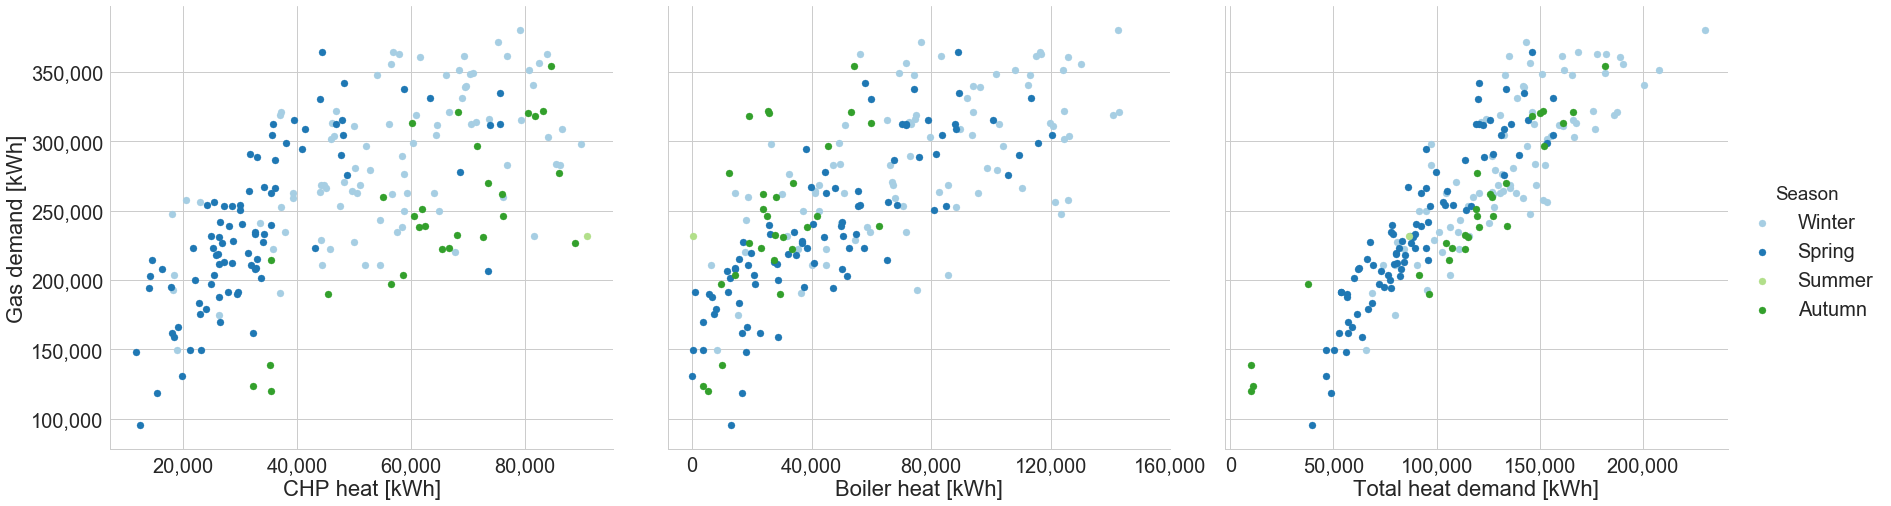

In [74]:
xlabels= ["CHP heat [kWh]", "Boiler heat [kWh]", "Total heat demand [kWh]"]
g = sns.PairGrid(resampled_df, x_vars=["CHP heat", "Boiler heat", "Heat demand"], y_vars="Gas demand", hue="Season", size=8)
g= g.map(plt.scatter)


for i in range(len(g.axes[0])):
    ax = g.axes[0][i]
    
    if len(ax.yaxis.get_label_text())>0:
        ax.yaxis.set_label_text("Gas demand [kWh]")
    
    
    ax.tick_params(labelsize=20)
    ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.xaxis.set_label_text(xlabels[i])

    xaxis=ax.get_xticks()
    xaxis=xaxis[np.where(xaxis>=0)]
    if len(xaxis)>7:   
        ax.set_xticks(xaxis[::2])

plt.subplots_adjust(top=0.9)
# g.fig.suptitle('Comparison of the daily consumption of gas with heat generated from CHPs and boilers')
g = g.add_legend()

plt.savefig(path+"gas against heat.png", bbox_inches='tight')

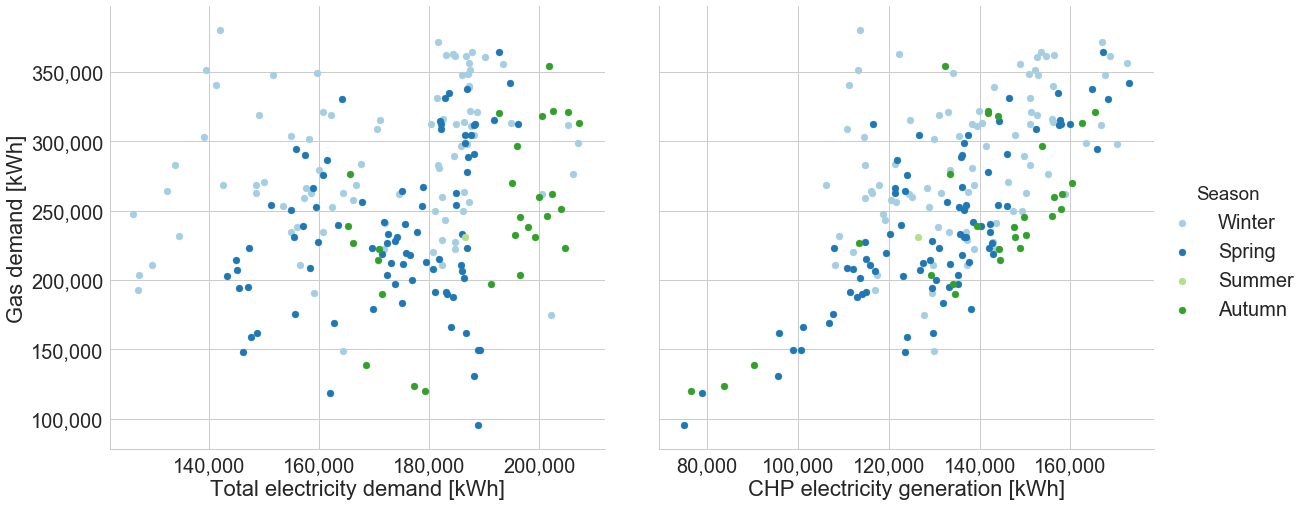

In [75]:
xlabels= ["Total electricity demand [kWh]", "CHP electricity generation [kWh]"]
g = sns.PairGrid(resampled_df, x_vars=["Electricity demand", "CHP elec"], y_vars="Gas demand", hue="Season", size=8)
g= g.map(plt.scatter)



for i in range(len(g.axes[0])):
    
    if len(ax.yaxis.get_label_text())>0:
        ax.yaxis.set_label_text("Gas demand [kWh]")
        
    ax = g.axes[0][i]
    ax.tick_params(labelsize=20)
    ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    
    ax.xaxis.set_label_text(xlabels[i])
    
    xaxis=ax.get_xticks()
    xaxis=xaxis[np.where(xaxis>=0)]
    if len(xaxis)>7:   
        ax.set_xticks(xaxis[::2])


plt.subplots_adjust(top=0.9)
# g.fig.suptitle('Comparison of the daily consumption of gas with the total electricity demand and the electricity from CHPs')
g = g.add_legend()

plt.savefig(path+"gas against elec.png", bbox_inches='tight')

In [76]:
resample='h'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)
df = resampled_df[["Heat demand", "Electricity demand", "Season", "Date", "Hour"]].copy()
# df["HH"] = [x%48 for x in range(0, df.shape[0], 1) ]
df["Date"] = df.index.date

In [77]:
daybyHH = df.groupby(["Season", "Date", "Hour"]).mean()
daybyHH=daybyHH.unstack("Hour").reset_index()
daybyHH["Date"]=pd.to_datetime(daybyHH["Date"], format="%Y-%m-%d")
daybyHH.set_index(["Season", "Date"], inplace=True, drop=True)
# daybyHH.dropna(how='any', inplace=True)

## Replacing outliers 5% - 95% limits before clustering (using winsorize method)

In [78]:
x = mstats.winsorize(daybyHH.values, limits=[0.05, 0.05])
daybyHH.loc[:, (slice(None), slice(None))] = x
daybyHH.describe()

Heat demand                                                        \
Hour           0        1        2        3        4        5        6    
count      366.00   366.00   366.00   366.00   366.00   366.00   366.00   
mean     2,715.29 2,850.69 2,753.49 2,713.20 2,828.60 3,248.77 3,215.40   
std      2,203.57 2,272.66 2,351.79 2,294.81 2,356.19 2,575.96 2,522.57   
min         50.00    50.00    50.00    50.00    50.00    50.00    50.00   
25%        485.00   605.00   482.50   435.00   495.00   745.00   700.00   
50%      2,530.00 2,650.00 2,380.00 2,340.00 2,430.00 3,005.00 3,100.00   
75%      4,527.50 4,690.00 4,627.50 4,577.50 4,667.50 5,272.50 5,217.50   
max      9,176.00 9,176.00 9,176.00 9,176.00 9,176.00 9,176.00 9,176.00   

                                   ...    Electricity demand           \
Hour        7        8        9    ...                    14       15   
count   366.00   366.00   366.00   ...                366.00   366.00   
mean  3,665.23 3,616.90 3,551.62   ...              8,178.87 8,080.54   
std   2,898.54 2,965.00 2,890.17   ...              1,059.91 1,017.24   
min      50.00    50.00    50.00   ...              5,337.00 5,402.00   
25%     730.00   612.50   797.50   ...              7,223.25 7,239.50   
50%   3,485.00 3,085.00 3,015.00   ...              8,578.00 8,358.00   
75%   5,942.50 6,255.00 5,942.50   ...              9,176.00 8,993.50   
max   9,176.00 9,176.00 9,176.00   ...              9,176.00 9,176.00   

                                                                               
Hour        16       17       18       19       20       21       22       23  
count   366.00   366.00   366.00   366.00   366.00   366.00   366.00   366.00  
mean  7,955.96 7,819.36 7,676.16 7,461.47 7,192.36 6,849.41 6,565.39 6,319.49  
std     940.94   907.52   886.03   798.78   686.36   585.63   475.80   439.83  
min   5,575.00 5,523.00 5,472.00 5,425.00 5,307.00 5,265.00 5,187.00 4,431.00  
25%   7,322.25 7,190.50 7,091.25 6,878.25 6,678.00 6,430.75 6,225.25 5,977.25  
50%   8,008.50 7,741.50 7,600.00 7,381.00 7,171.00 6,846.00 6,586.00 6,354.00  
75%   8,802.75 8,605.25 8,421.75 8,041.00 7,701.00 7,221.75 6,895.50 6,585.50  
max   9,176.00 9,176.00 9,176.00 9,176.00 8,889.00 8,284.00 7,776.00 7,476.00  

[8 rows x 48 columns]

In [79]:
columns= daybyHH["Heat demand"].columns.tolist()
index_season = daybyHH.index.get_level_values(0).unique().tolist()


In [80]:
from sklearn.cluster import KMeans
from sklearn import metrics

def cluster(values):
    algorithm = "elkan"
    max_silhouette = 0.
    max_nb_values_over = 0.
    cluster_centers=[]
    cluster_labels=[]
    for n_clusters in range(2, 17, 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=10, algorithm="elkan", n_init=30).fit(values)
        labels_temp= kmeans.labels_
        silhouette_avg = metrics.silhouette_score(values, labels_temp)
        
        silhouette_samples_values = metrics.silhouette_samples(values, labels_temp)
        calinski_harabaz_score= metrics.calinski_harabaz_score(values, labels_temp)
        nb_values_over = 0
        print("cluster:", n_clusters , "silhouette score:" ,silhouette_avg, "calinski_harabaz:",calinski_harabaz_score )
#         if max_silhouette<silhouette_avg:
#             max_silhouette=silhouette_avg
#             cluster_centers= kmeans.cluster_centers_
#             cluster_labels= labels_temp


        nb_values_over = len(silhouette_samples_values[np.where(silhouette_samples_values>silhouette_avg)])
        print("Number of values over average:", nb_values_over, "({:04.1f}%)".format(nb_values_over/len(values)*100)) 
        
        if max_nb_values_over<nb_values_over:
            max_nb_values_over=nb_values_over
            cluster_centers= kmeans.cluster_centers_
            cluster_labels= labels_temp

        
    return cluster_centers.shape[0], cluster_centers, cluster_labels

In [81]:
from itertools import repeat
target= "Electricity demand"
frame = []
index_season=[]
index_cluster = []

for season in daybyHH.index.get_level_values(0).unique():
    print(season)
    nb_clusters, cluster_centers, cluster_labels = cluster(daybyHH.loc[season, target].values)
#     daybyHH[target].loc[season, "Labels Kmeans"] = cluster_labels
    index_cluster.append(set(cluster_labels))
    
    for x in repeat(season, nb_clusters):
        index_season.append(x)
    
    frame.append(cluster_centers)

index_cluster = [y for x in index_cluster for y in x]
# daybyHH.set_index("Labels Kmeans", append=True, inplace=True)
frame = [y for x in frame for y in x]

Autumn
cluster: 2 silhouette score: 0.560985700886 calinski_harabaz: 160.33991265
Number of values over average: 61 (67.0%)
cluster: 3 silhouette score: 0.537779182361 calinski_harabaz: 183.24351442
Number of values over average: 58 (63.7%)
cluster: 4 silhouette score: 0.560785121079 calinski_harabaz: 205.35720208
Number of values over average: 63 (69.2%)
cluster: 5 silhouette score: 0.570811580701 calinski_harabaz: 284.696430332
Number of values over average: 57 (62.6%)
cluster: 6 silhouette score: 0.541069164071 calinski_harabaz: 280.339709223
Number of values over average: 59 (64.8%)
cluster: 7 silhouette score: 0.495438607805 calinski_harabaz: 273.37064109
Number of values over average: 57 (62.6%)
cluster: 8 silhouette score: 0.490133741943 calinski_harabaz: 263.433372525
Number of values over average: 53 (58.2%)
cluster: 9 silhouette score: 0.44653975118 calinski_harabaz: 258.322601235
Number of values over average: 49 (53.8%)
cluster: 10 silhouette score: 0.392274138049 calinski_

In [82]:
index= pd.MultiIndex.from_tuples(list(zip(index_season, index_cluster)), names=['Season', 'Kmeans labels'])
df_to_plot=pd.DataFrame(frame, index=index, columns=columns)
df_to_plot=df_to_plot.transpose()
df_to_plot.head()

Season          Autumn                              Spring            Summer  \
Kmeans labels        0        1        2        3        0        1        0   
0             6,468.76 5,688.40 5,731.05 6,419.38 6,176.94 6,092.73 5,948.92   
1             6,293.71 5,662.30 5,697.50 6,293.62 6,062.94 5,995.40 5,901.03   
2             6,158.53 5,570.50 5,642.45 6,163.62 5,942.15 5,894.87 5,798.08   
3             6,069.98 5,518.70 5,549.75 6,048.19 5,873.53 5,822.13 5,703.97   
4             6,037.42 5,517.80 5,647.10 5,971.19 5,822.52 5,748.87 5,592.82   

Season                   Winter                    
Kmeans labels        1        0        1        2  
0             5,850.07 5,536.14 6,411.22 6,101.00  
1             5,781.30 5,504.29 6,222.18 5,983.79  
2             5,710.37 5,491.00 6,084.24 5,887.18  
3             5,634.93 5,459.36 6,015.67 5,826.25  
4             5,504.37 5,396.64 5,949.27 5,761.71

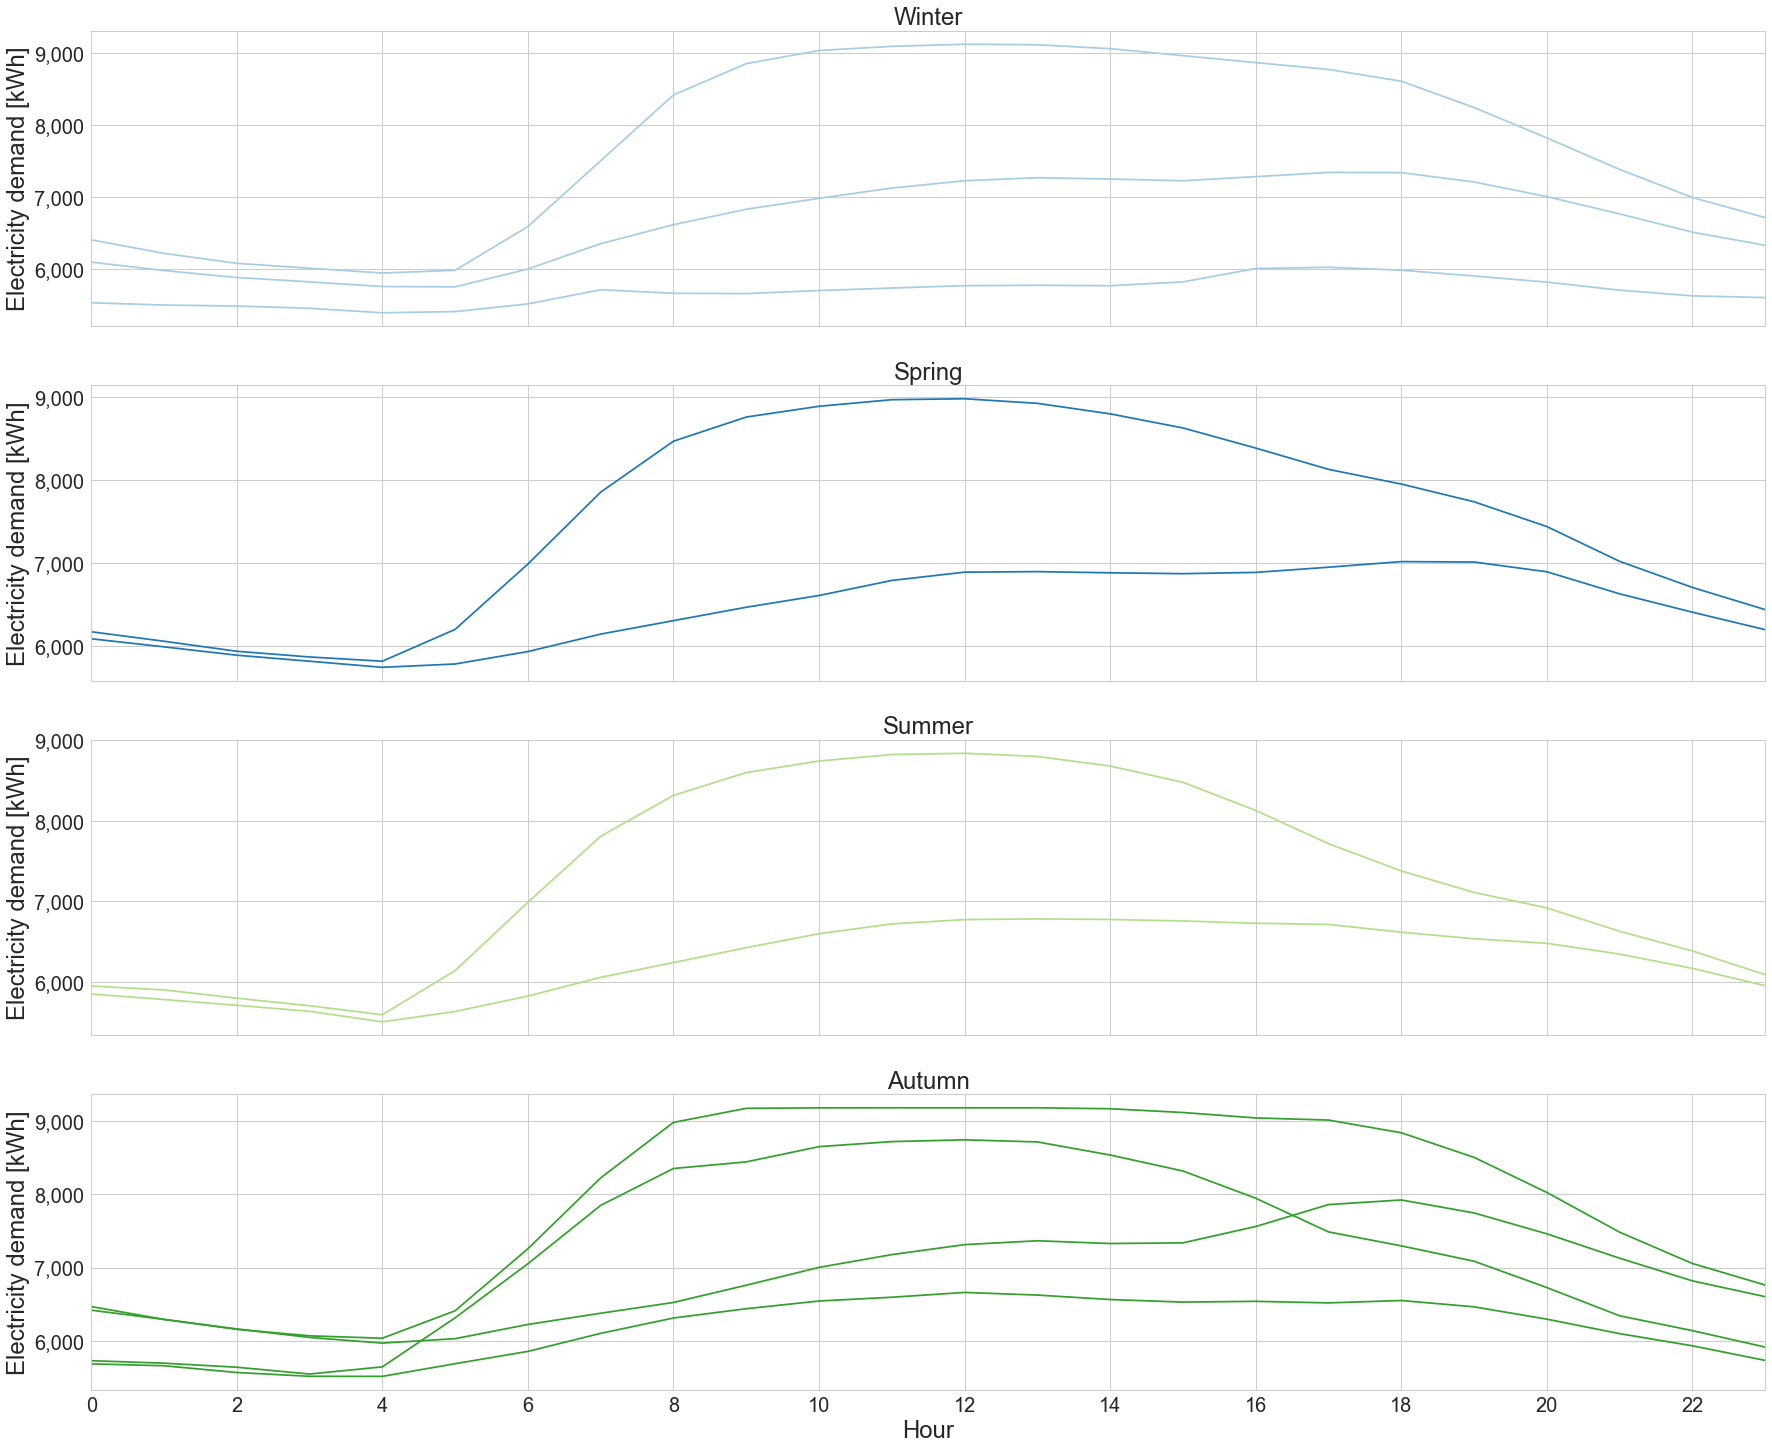

In [83]:
f, a = plt.subplots(4,1, figsize=(30,25))
f.subplots_adjust(hspace=.2)
count=0

for season in season_dict.keys():
    df_to_plot.xs(season, axis=1).plot(ax=a[count], color=sns.color_palette().as_hex()[count], legend=False, title=season)
#     a[count].xaxis.label.set_visible(False)
    a[count].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    a[count].set_ylabel("Electricity demand [kWh]", fontsize=24)
#     a[len(season_dict.keys())-1].set_xlabel("Hour", fontsize=24)
    a[count].tick_params(labelsize=20)
    a[count].set_xticks(np.arange(0, 23, 2))  
    a[count].tick_params(labelbottom='off')  
    count=count+1

a[len(season_dict.keys())-1].tick_params(labelbottom='on')  
a[len(season_dict.keys())-1].set_xticks(np.arange(0, 23, 2))    
a[len(season_dict.keys())-1].set_xlabel("Hour", fontsize=24)

plt.savefig(path+target+ " profiles.png", bbox_inches='tight')

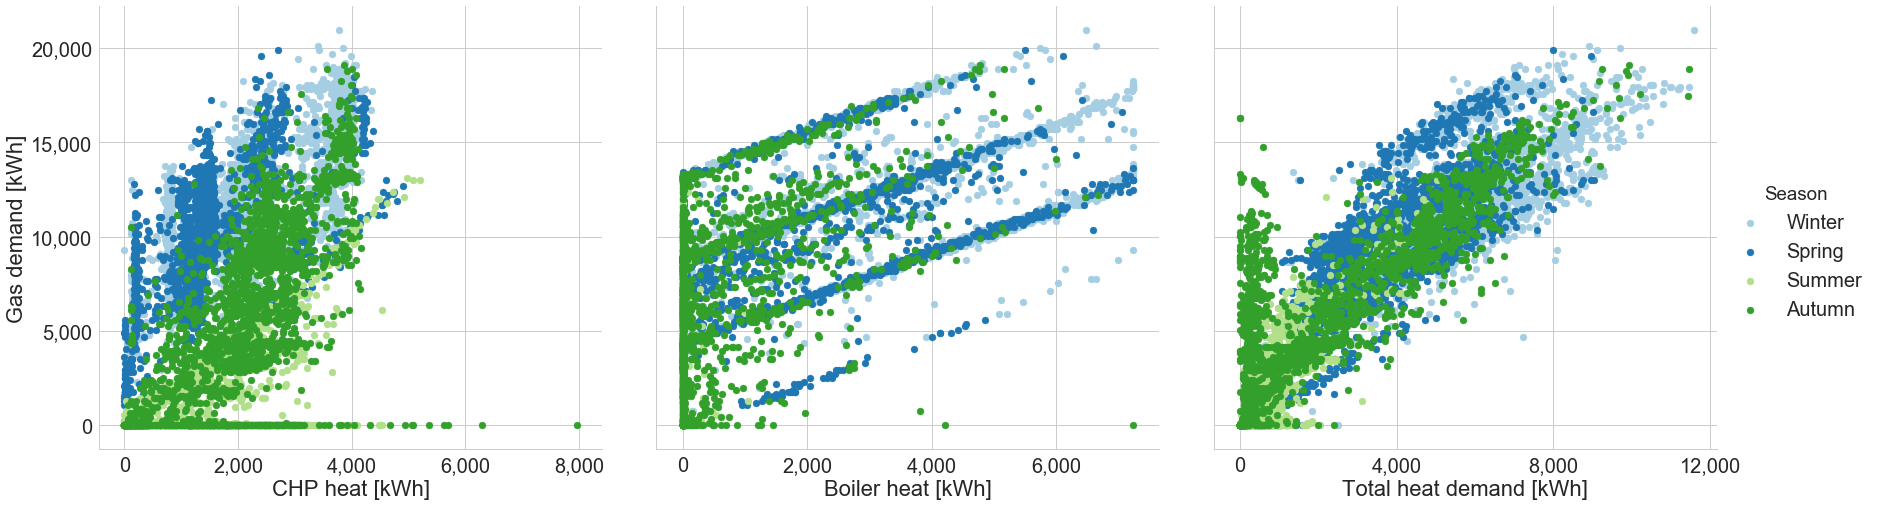

In [84]:
xlabels= ["CHP heat [kWh]", "Boiler heat [kWh]", "Total heat demand [kWh]"]
g = sns.PairGrid(resampled_df, x_vars=["CHP heat", "Boiler heat", "Heat demand"], y_vars="Gas demand", hue="Season", size=8)
g= g.map(plt.scatter)


for i in range(len(g.axes[0])):
    ax = g.axes[0][i]
    
    if len(ax.yaxis.get_label_text())>0:
        ax.yaxis.set_label_text("Gas demand [kWh]")
    
    
    ax.tick_params(labelsize=20)
    ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.xaxis.set_label_text(xlabels[i])

    xaxis=ax.get_xticks()
    xaxis=xaxis[np.where(xaxis>=0)]
    if len(xaxis)>7:   
        ax.set_xticks(xaxis[::2])

plt.subplots_adjust(top=0.9)
# g.fig.suptitle('Comparison of the daily consumption of gas with heat generated from CHPs and boilers')
g = g.add_legend()

# plt.savefig(path+"gas against heat.png", bbox_inches='tight')

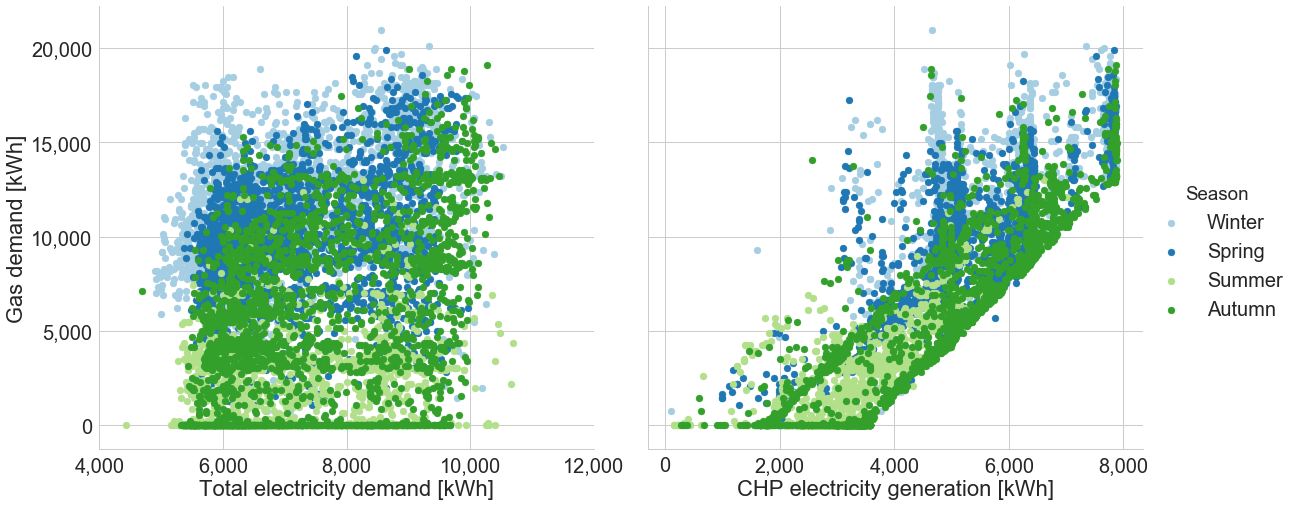

In [85]:
xlabels= ["Total electricity demand [kWh]", "CHP electricity generation [kWh]"]
g = sns.PairGrid(resampled_df, x_vars=["Electricity demand", "CHP elec"], y_vars="Gas demand", hue="Season", size=8)
g= g.map(plt.scatter)



for i in range(len(g.axes[0])):
    
    if len(ax.yaxis.get_label_text())>0:
        ax.yaxis.set_label_text("Gas demand [kWh]")
        
    ax = g.axes[0][i]
    ax.tick_params(labelsize=20)
    ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    
    ax.xaxis.set_label_text(xlabels[i])
    
    xaxis=ax.get_xticks()
    xaxis=xaxis[np.where(xaxis>=0)]
    if len(xaxis)>7:   
        ax.set_xticks(xaxis[::2])


plt.subplots_adjust(top=0.9)
# g.fig.suptitle('Comparison of the daily consumption of gas with the total electricity demand and the electricity from CHPs')
g = g.add_legend()

# plt.savefig(path+"gas against elec.png", bbox_inches='tight')

In [86]:
resample='d'
resampled_df = result.resample(resample).sum()
addTimePeriod(resampled_df)

In [87]:
df_melted = pd.melt(resampled_df[["Boiler heat", "CHP heat", "CHP elec" ,"Electricity demand", "Heat demand", "Season"]], "Season", var_name="measurement")

In [88]:
df_melted.sort_values("value", inplace=True)

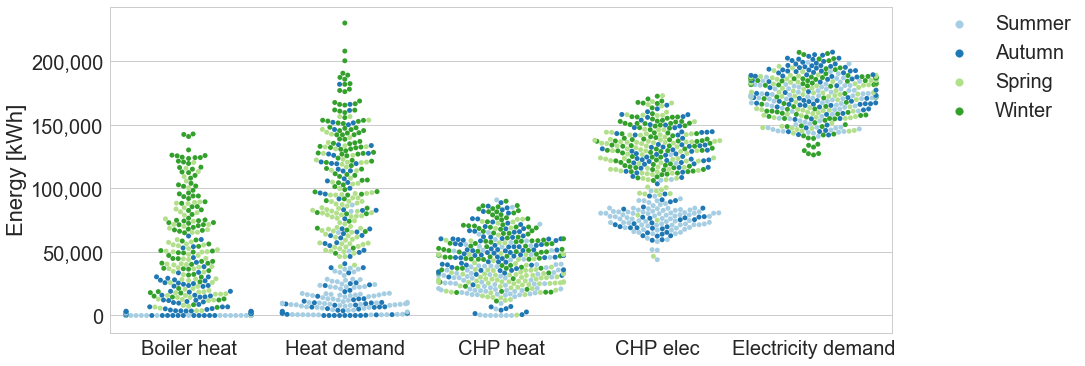

In [89]:
fig, ax = plt.subplots(figsize=(14, 6))
# Draw a categorical scatterplot to show each observation
g = sns.swarmplot(x="measurement", y="value", hue="Season", data=df_melted)
plt.legend(prop={'size':20}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.axes.yaxis.set_label_text("Energy [kWh]")
g.axes.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
g.axes.xaxis.set_label_text("")

plt.savefig(path+"swarmplot.png", bbox_inches='tight')

In [94]:
resample='h'
load_duration= result.resample(resample).sum().sort_values("Heat demand", ascending=False).copy()
load_duration.reset_index(inplace=True)
load_duration["Value"] = load_duration.index
load_duration['CHP heat']=load_duration['CHP heat']-load_duration["Dumped heat"]*1000
load_duration['Boiler heat']=load_duration['Boiler heat']+load_duration['CHP heat']
load_duration['Heat gen - Heat demand']=load_duration['Heat gen - Heat demand']*1000
load_duration["Dumped heat"] = -load_duration["Dumped heat"]*1000

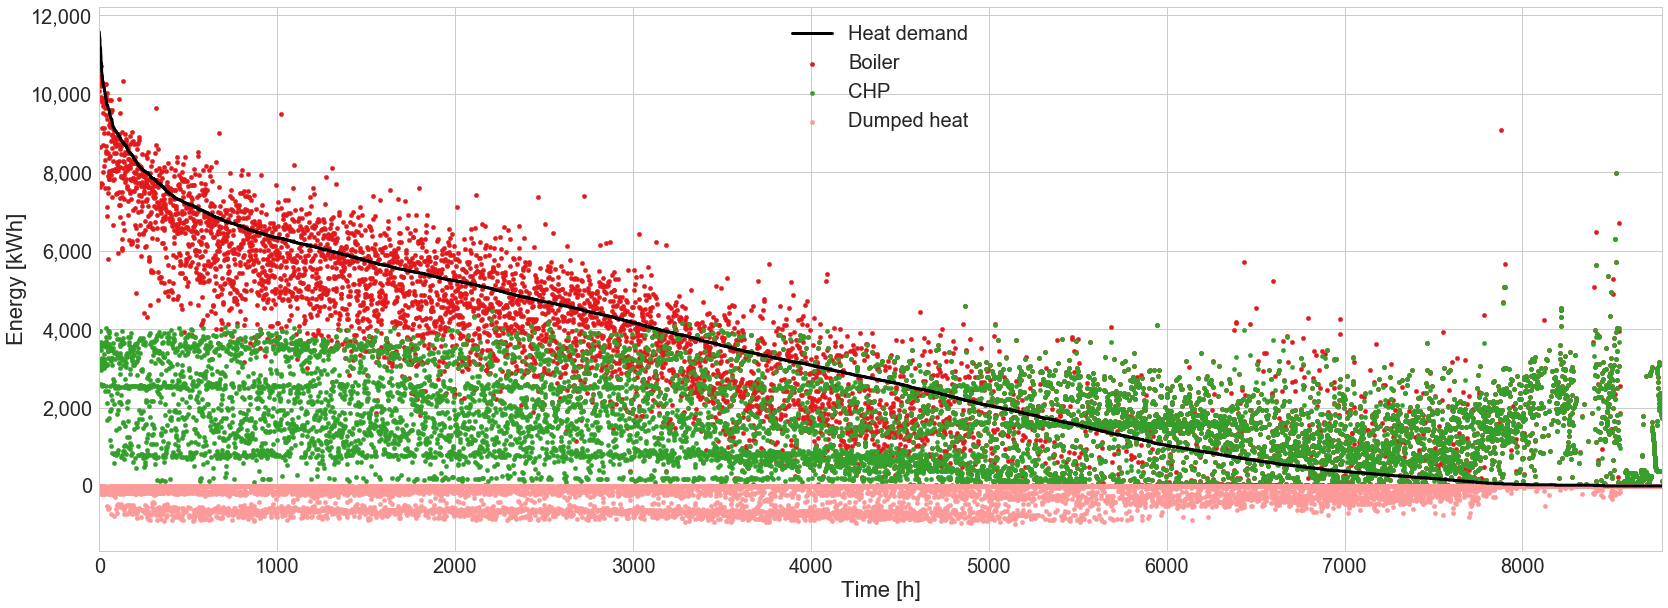

In [95]:
fig, ax = plt.subplots(figsize=(28, 10))

# load_duration.plot(ax=fig.gca(),linewidth=2,x="Month name", y=["CHP heat", "Boiler heat"], stacked=True, fontsize=20)
load_duration[["Heat demand"]].plot(ax=fig.gca(), linewidth=3, color='black')
load_duration.plot.scatter(ax=fig.gca(), x="Value", y='Boiler heat', color=sns.color_palette()[5], label="Boiler")
load_duration.plot.scatter(ax=fig.gca(), x="Value", y='CHP heat', color=sns.color_palette()[3], label="CHP")
load_duration.plot.scatter(ax=fig.gca(), x="Value", y='Dumped heat', color=sns.color_palette()[4], label="Dumped heat")
# load_duration.plot.scatter(ax=fig.gca(), x="Value", y='Heat gen - Heat demand', color='purple')


# lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.yaxis.set_label_text("Energy [kWh]")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_label_text("Time [h]")

plt.savefig(path+"load_duration.png", bbox_inches='tight')

In [92]:
load_duration.head()

,index,Boiler heat,CHP elec,CHP heat,Dumped heat,Heat gen - Heat demand,Electricity demand,Gas demand,Heat demand,Hour,DayOfWeek,Month,Weekday,HH,Week,Season num,Value
0,2016-12-12 08:00:00,"10,259.81","4,665.00","3,779.81",-0.19,"-3,462.00","8,560.00","20,960.00","11,580.00",16,0,24,2,33,100,2,0
1,2016-11-08 08:00:00,"8,709.94","4,646.00","4,009.94",-0.06,"-3,233.00","9,006.00","18,885.00","11,460.00",16,2,22,2,33,90,8,1
2,2016-12-29 07:00:00,"10,859.89","4,764.00","3,619.89",-0.11,"-2,237.00","6,063.00","17,904.00","11,450.00",14,6,24,2,29,104,2,2
3,2016-11-08 07:00:00,"7,659.96","4,616.00","3,989.96",-0.04,"-4,139.00","7,903.00","17,466.00","11,430.00",14,2,22,2,29,90,8,3
4,2016-12-29 09:00:00,"10,629.83","4,762.00","3,389.83",-0.17,"-2,569.00","5,952.00","17,904.00","11,230.00",18,6,24,2,37,104,2,4


In [93]:
for demand in ["Electricity demand", "Heat demand", "Gas demand"]:
     for season in season_dict:
        avg_week = pd.pivot_table(result.loc[result["Season"]==season, :], values=demand, index="Week", columns=["DayOfWeek" ,"Hour"], aggfunc=np.sum).mean()
#         avg_week.to_csv(path+demand+"_"+season+".csv")